### machine learning 5-fold comparison

In [11]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [14]:
# prepare (flatten) 5-fold dataset features and labels
feature_list_train_all = []
label_list_train_all = []

for i in range(5):

    trainpath = '../datasets/fivefold/'+str(i+1)+'fold_train_evidence.dataset'
    validpath = '../datasets/fivefold/'+str(i+1)+'fold_valid_evidence.dataset'
    train = pd.read_pickle(trainpath)
    test = pd.read_pickle(validpath)

    # fold-i label
    label_train = train['label'].values
    label_list_train_all.append(label_train)

    # fold-i features
    feature = np.zeros(shape=(train.shape[0],7225))
    for j in range(train.shape[0]):
        feature_list = []
        for item in train['fingerprint'][j]:
            feature_list.append(item) # 881
        for item in np.nditer(train['seqbefore'][j]):
            feature_list.append(item) # 1220
        for item in np.nditer(train['seqafter'][j]):
            feature_list.append(item) # 1220
        for item in train['variantfeature'][j]:
            feature_list.append(item) # 3904
        for k in range(len(feature_list)):
            feature[j, k] = feature_list[k]
    feature_list_train_all.append(feature)

feature_train_all = np.array(feature_list_train_all)
label_train_all = np.array(label_list_train_all)

print(feature_train_all.shape) # (5,480,7225)
print(label_train_all.shape) # (5,480)


(5, 440, 7225)
(5, 440)


In [15]:
# prepare (flatten) testset features and labels
alltestpath = '../datasets/middlefile/test_data_evidence.dataset'
alltest = pd.read_pickle(alltestpath)
label = alltest['label'].values
feature = np.zeros(shape=(alltest.shape[0],7225))
for j in range(alltest.shape[0]):
    feature_list = []
    for item in alltest['fingerprint'][j]:
        feature_list.append(item) # 881
    for item in np.nditer(alltest['seqbefore'][j]):
        feature_list.append(item) # 1220
    for item in np.nditer(alltest['seqafter'][j]):
        feature_list.append(item) # 1220
    for item in alltest['variantfeature'][j]:
        feature_list.append(item) # 3904
    for k in range(len(feature_list)):
        feature[j, k] = feature_list[k]
print(feature.shape) # (153, 7225)
print(label.shape) # (153,)

(160, 7225)
(160,)


In [16]:
label_train_all = label_train_all.astype('int')
label = label.astype('int')

In [22]:
print(feature_train_all[0])

[[1. 1. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 0. 0.]
 ...
 [1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 0. 0.]]


#### Model 1: Decision tree

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

paramGride = dict(
    max_depth = [1,3,5,10,15,20],
    max_leaf_nodes = [2,3,4,5,10,15,20],)

dtModel = DecisionTreeClassifier()
grid = GridSearchCV(
    dtModel,paramGride,cv = 5,return_train_score = True)
grid = grid.fit(feature_train_all[0],label_train_all[0])

In [6]:
print('best_score：%f'% grid.best_score_)
print('best paramaters:')

for key in grid.best_params_.keys():
    print('%s = %s'%(key,grid.best_params_[key]))

best_score：0.787500
best paramaters:
max_depth = 10
max_leaf_nodes = 10


(mean) ACC:  0.8525 Precision:  0.8666026631921877 Recall:  0.9385964912280702 F1:  0.9007211119298713 AUC:  0.883015625
(std) ACC:  0.026692695630078263 Precision:  0.027066632586772443 Recall:  0.02660658050544403 F1:  0.017809683117514057 AUC:  0.03977513546635873


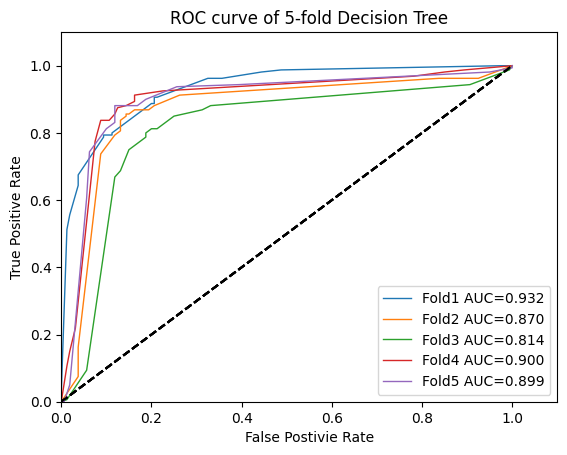

In [17]:
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

dt_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_dt = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=10)
    clf_dt.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_dt.predict(feature)                                   
    y_score_pro = clf_dt.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    dt_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold Decision Tree')
plt.savefig('images/roc-5fold-decision-tree.png',dpi=300)
plt.show()

#### Model 2: Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

paramGride = dict(
    n_estimators = [3,5,10,15],
    max_depth = [11,15,20],
    min_samples_split = [10,20,40,60],)

rfModel = RandomForestClassifier()
grid = GridSearchCV(
    rfModel,paramGride,cv = 5,return_train_score = True)
grid = grid.fit(feature_train_all[0],label_train_all[0])

In [41]:
print('best_score：%f'% grid.best_score_)
print('best paramaters:')

for key in grid.best_params_.keys():
    print('%s = %s'%(key,grid.best_params_[key]))

best_score：0.754167
best paramaters:
max_depth = 11
min_samples_split = 10
n_estimators = 10


(mean) ACC:  0.8150000000000001 Precision:  0.8318977236018574 Recall:  0.9280701754385964 F1:  0.8773165710726186 AUC:  0.8815664062500002
(std) ACC:  0.01015504800579495 Precision:  0.010543354991519387 Recall:  0.0035087719298245727 F1:  0.0059753064617745835 AUC:  0.008175963216142702


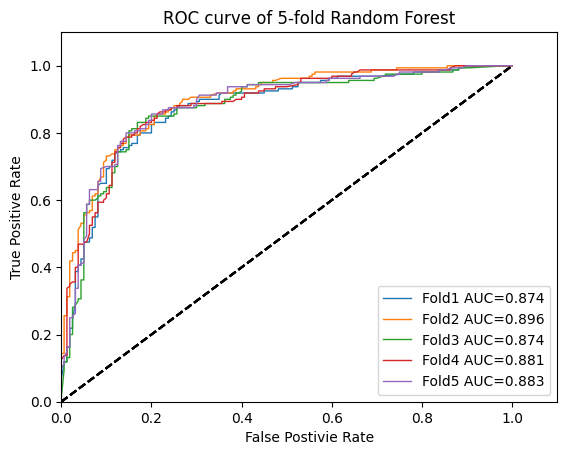

In [18]:
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

rf_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_rf = RandomForestClassifier(n_estimators=10, max_depth=11, min_samples_split=10)
    clf_rf.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_rf.predict(feature)                                   
    y_score_pro = clf_rf.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    rf_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold Random Forest')
plt.savefig('images/roc-5fold-random-forest.png',dpi=300)
plt.show()

#### Model 3: SVM

In [43]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

paramGride = dict(
    gamma = [1e-4, 1e-3, 0.01, 0.1, 1, 10],
    C = [100, 10, 1, 0.1, 1e-2, 1e-3],)

svmModel = SVC()
grid = GridSearchCV(
    svmModel,paramGride,cv = 5,return_train_score = True)
grid = grid.fit(feature_train_all[0],label_train_all[0])

print('best_score：%f'% grid.best_score_)
print('best paramaters:')

for key in grid.best_params_.keys():
    print('%s = %s'%(key,grid.best_params_[key]))

best_score：0.737500
best paramaters:
C = 10
gamma = 0.0001


(mean) ACC:  0.7449999999999999 Precision:  0.7440393225258036 Recall:  0.9789473684210526 F1:  0.8454539712780307 AUC:  0.7959609375000001
(std) ACC:  0.00467707173346741 Precision:  0.004221943768282526 Recall:  0.0070175438596491 F1:  0.002686177410298637 AUC:  0.006743350674576564


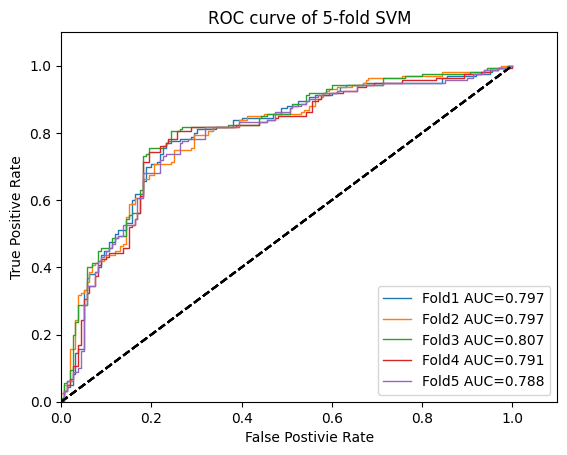

In [19]:
from sklearn.svm import SVC
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

svm_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_svm = SVC(probability = True)
    clf_svm.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_svm.predict(feature)                                   
    y_score_pro = clf_svm.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    svm_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold SVM')
plt.savefig('images/roc-5fold-svm.png',dpi=300)
plt.show()

#### Model 4: KNN

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

paramGride = dict(
    n_neighbors = [20,30,40,50,60,70,80,100],)

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True,scoring='roc_auc')
grid = grid.fit(feature_train_all[0],label_train_all[0])

print('best_score：%f'% grid.best_score_)
print('best paramaters:')

for key in grid.best_params_.keys():
    print('%s = %s'%(key,grid.best_params_[key]))

best_score：0.639916
best paramaters:
n_neighbors = 40


(mean) ACC:  0.7112499999999999 Precision:  0.7153706609443125 Recall:  0.9877192982456139 F1:  0.8297635241058293 AUC:  0.8137421875000002
(std) ACC:  0.006123724356957965 Precision:  0.002604634225436706 Recall:  0.0070175438596491 F1:  0.003953207501065842 AUC:  0.00799229250603062


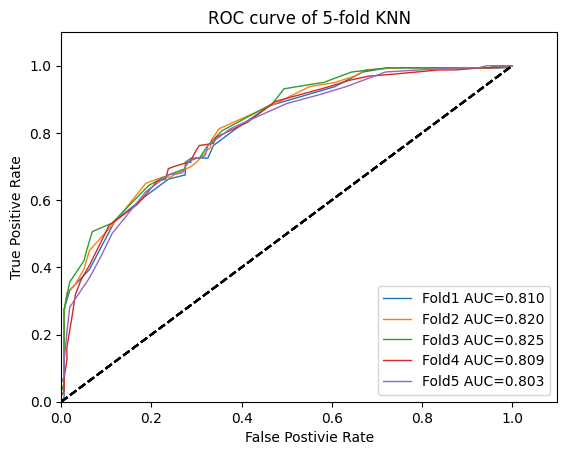

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

knn_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_knn = KNeighborsClassifier(n_neighbors = 40)
    clf_knn.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_knn.predict(feature)                                   
    y_score_pro = clf_knn.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    knn_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold KNN')
plt.savefig('images/roc-5fold-knn.png',dpi=300)
plt.show()

#### Model 5: XGBoost

In [23]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

other_params = {'eta': 0.3, 'n_estimators': 50, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1,
                'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0,
                'seed': 33}

cv_params = {'n_estimators': np.linspace(1, 10, 11, dtype=int)} 
# cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 

xgb_model = xgb.XGBClassifier(**other_params)
gs = GridSearchCV(xgb_model, cv_params, verbose=2, refit=True, cv=5, n_jobs=-1)
gs.fit(feature_train_all[0],label_train_all[0])
gs.best_params_

Fitting 5 folds for each of 11 candidates, totalling 55 fits


{'n_estimators': 5}

(mean) ACC:  0.8575000000000002 Precision:  0.8891643627512643 Recall:  0.9140350877192983 F1:  0.9012895508394634 AUC:  0.93378125
(std) ACC:  0.02069118169655857 Precision:  0.013193892155799502 Recall:  0.023141940277671816 F1:  0.014997307260198028 AUC:  0.007745903655319968


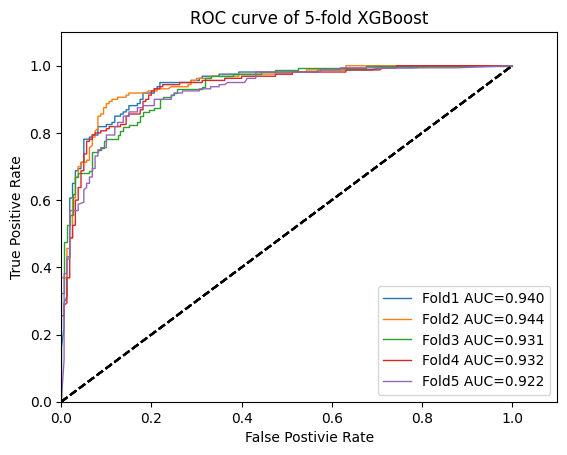

In [21]:
import xgboost as xgb
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

xgb_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5):

    clf_xgb = xgb.XGBClassifier(n_estimators=5)
    clf_xgb.fit(feature_train_all[i],label_train_all[i])

    y_score = clf_xgb.predict(feature)                               
    y_score_pro = clf_xgb.predict_proba(feature) # (.., 2)
    y_one_hot = to_categorical(label)
    y_score_one_hot = to_categorical(y_score)

    xgb_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, y_score))
    precision_list.append(precision_score(label, y_score))
    recall_list.append(recall_score(label, y_score))
    f1_list.append(f1_score(label, y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold XGBoost')
plt.savefig('images/roc-5fold-xgb.png',dpi=300)
plt.show()

#### Emden

[0.8, 0.8384615384615385, 0.8307692307692308, 0.8076923076923077, 0.7923076923076923]
[0.8588235294117647, 0.83, 0.8217821782178217, 0.8163265306122449, 0.8571428571428571]
[0.8390804597701149, 0.9540229885057471, 0.9540229885057471, 0.9195402298850575, 0.8275862068965517]
[0.8488372093023254, 0.8877005347593583, 0.8829787234042553, 0.8648648648648648, 0.8421052631578947]
[0.8868639053254438, 0.9034911242603552, 0.885562130177515, 0.8782248520710059, 0.8582840236686391]
(mean) ACC:  0.8138461538461538 Precision:  0.8368150190769377 Recall:  0.8988505747126437 F1:  0.8652973190977397 AUC:  0.8824852071005918
(std) ACC:  0.017808979850446518 Precision:  0.017831458024933394 Recall:  0.05507654506073994 F1:  0.018019599441102933 AUC:  0.014654261591589016


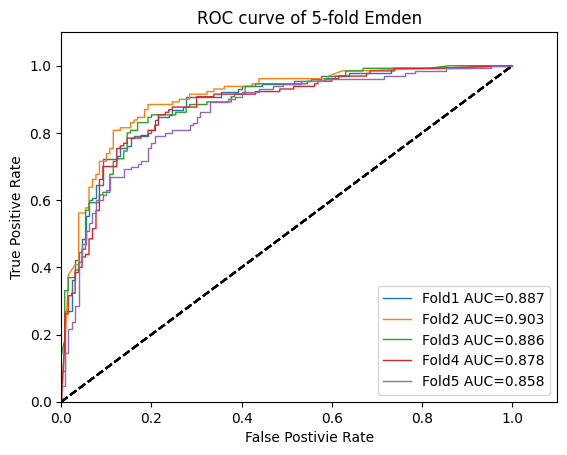

In [31]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

def softmax(vec):
    """Compute the softmax in a numerically stable way."""
    vec = vec - np.max(vec)  # softmax(x) = softmax(x+c)
    exp_x = np.exp(vec)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

emden_prob_list = []

for i in range(5):
    label = np.load('E:/Emden-20230339/Emden-restart/model/pred_results_5fold/' + str(i+1) + 'fold_label.npy')
    pred = np.load('E:/Emden-20230339/Emden-restart/model/pred_results_5fold/' + str(i+1) + 'fold_pred.npy')
    prob = np.load('E:/Emden-20230339/Emden-restart/model/pred_results_5fold/' + str(i+1) + 'fold_pred_prob.npy')
    raw = np.load('E:/Emden-20230339/Emden-restart/model/pred_results_5fold/' + str(i+1) + 'fold_pred_raw.npy')

    '''
    print(label)
    print(pred)
    #print(prob)
    print(raw)
    '''

    y_one_hot = to_categorical(label)
    y_score_pro_list = []
    for j in range(prob.shape[0]):
        y_score_pro_list.append([1-prob[j],prob[j]])
    y_score_pro = np.array(y_score_pro_list)

    emden_prob_list.append(y_score_pro)

    acc_list.append(accuracy_score(label, pred))
    precision_list.append(precision_score(label, pred))
    recall_list.append(recall_score(label, pred))
    f1_list.append(f1_score(label, pred))
    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print(acc_list)
print(precision_list)
print(recall_list)
print(f1_list)
print(auc_list)

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold Emden')
plt.savefig('images/roc-5fold-emden.png',dpi=300)
plt.show()

#### compare all

In [23]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

print(dt_prob_list[0].shape) # (160, 2)

def mean_prob(prob_list):
    sum_array = np.zeros((160,2))
    mean_array = np.zeros((160,2))
    for arr in prob_list:
        for i in range(160):
            sum_array[i][0] += arr[i][0]
            sum_array[i][1] += arr[i][1]
    for i in range(160):
        mean_array[i][0] = sum_array[i][0]/5
        mean_array[i][1] = sum_array[i][1]/5
    return mean_array

dt_prob = mean_prob(dt_prob_list)
rf_prob = mean_prob(rf_prob_list)
svm_prob = mean_prob(svm_prob_list)
knn_prob = mean_prob(knn_prob_list)
xgb_prob = mean_prob(xgb_prob_list)
emden_prob = mean_prob(emden_prob_list)

y_one_hot = to_categorical(label)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_one_hot.ravel(),dt_prob.ravel())
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_one_hot.ravel(),rf_prob.ravel())
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_one_hot.ravel(),svm_prob.ravel())
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_one_hot.ravel(),knn_prob.ravel())
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_one_hot.ravel(),xgb_prob.ravel())
fpr_emden, tpr_emden, thresholds_emden = roc_curve(y_one_hot.ravel(),emden_prob.ravel())

plt.plot(fpr_dt, tpr_dt, linewidth = 1,label='Decision Tree AUC=0.8181', color='#C497B2')
plt.plot(fpr_rf, tpr_rf, linewidth = 1,label='Random Forest AUC=0.8608', color='#A9B8C6')
plt.plot(fpr_svm, tpr_svm, linewidth = 1,label='SVM AUC=0.7829', color='#14517C')
plt.plot(fpr_knn, tpr_knn, linewidth = 1,label='KNN AUC=0.7879', color='#96C37D')
plt.plot(fpr_xgb, tpr_xgb, linewidth = 1,label='XGBoost AUC=0.8906', color='#8B814C')
plt.plot(fpr_emden, tpr_emden, linewidth = 1,label='Emden AUC=0.9194', color='#D8383A')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold average comparison')
plt.savefig('images/5fold-comparison.png',dpi=300)
plt.show()

(160, 2)


IndexError: index 153 is out of bounds for axis 0 with size 153